In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df=pd.read_csv(r'Irish_DataSet\finalDataForResidential.txt',header=None,delimiter=" ")
df.rename(columns={0: "ID", 1: "Date", 2: "Time", 3: "Consumption"},inplace=True)
def convert_date(day):
    base_date = datetime(2009, 1, 1)
    converted_date = base_date + timedelta(days=(day - 195))
    return converted_date

def convert_time(time):
    hours = (time - 1) // 2
    minutes = (time - 1) % 2 * 30
    return f"{(hours):02d}:{(minutes):02d}"

df

,ID,Date,Time,Consumption
0,1002,195,1,0.362
1,1002,195,2,0.064
2,1002,195,3,0.119
3,1002,195,4,0.023
4,1002,195,5,0.140
...,...,...,...,...
5873845,1998,365,46,1.242
5873846,1998,365,47,2.724
5873847,1998,365,48,1.853
5873848,1998,365,49,0.000


In [3]:
df['New_Date'] = df['Date'].apply(lambda x: convert_date(x).date())

In [4]:
df['New_Time'] = df['Time'].apply(convert_time)

In [12]:
df['New_Time'] = df['New_Time'].str.replace('24:00', '00:00')
df['New_Date'] = pd.to_datetime(df['New_Date'])
df['New_Time'] = pd.to_timedelta(df['New_Time'] + ':00')
df['Datetime'] = df['New_Date'] + df['New_Time']


In [14]:
df.head()

,ID,Date,Time,Consumption,New_Date,New_Time,Datetime
0,1002,195,1,0.362,2009-01-01,0 days 00:00:00,2009-01-01 00:00:00
1,1002,195,2,0.064,2009-01-01,0 days 00:30:00,2009-01-01 00:30:00
2,1002,195,3,0.119,2009-01-01,0 days 01:00:00,2009-01-01 01:00:00
3,1002,195,4,0.023,2009-01-01,0 days 01:30:00,2009-01-01 01:30:00
4,1002,195,5,0.140,2009-01-01,0 days 02:00:00,2009-01-01 02:00:00


In [18]:
df.set_index(df['Datetime'],inplace=True)

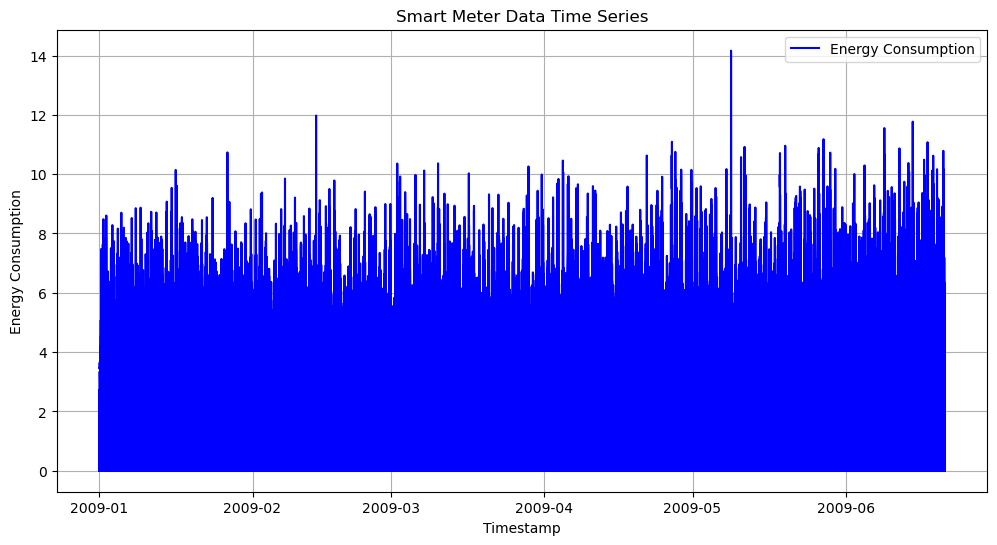

In [19]:
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(df.index, df['Consumption'], label='Energy Consumption', color='blue')
plt.title('Smart Meter Data Time Series')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()